# Generate "clean" Other subset

In this notebook, we'll read the cleaned PBMC reference dataset, select L1 cell types, and generate subset AnnData objects for each with updated UMAP projections.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from datetime import date
import hisepy
import os
import pandas as pd
import scanpy as sc
import scanpy.external as sce

In [2]:
def read_adata_uuid(h5ad_uuid):
    h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)
    if not os.path.isdir(h5ad_path):
        hise_res = hisepy.reader.cache_files([h5ad_uuid])
    h5ad_filename = os.listdir(h5ad_path)[0]
    h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)
    adata = sc.read_h5ad(h5ad_file)
    return adata

In [3]:
out_dir = 'output'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir)

In [4]:
out_files = []

## Read annotated dataset

In [5]:
h5ad_uuid = '6e8972a5-9463-4230-84b4-a20de055b9c3'

In [6]:
adata = read_adata_uuid(h5ad_uuid)

In [7]:
adata.shape

(1823666, 1261)

## Generate Other cell object

In [8]:
cell_class = 'other'
keep_labels = ['Erythrocyte', 'Platelet', 'Progenitor cell']

In [9]:
adata_subset = adata[adata.obs['AIFI_L1'].isin(keep_labels)]
adata_subset.shape

(10937, 1261)

In [10]:
obs = adata_subset.obs.copy()
obs['AIFI_L1'] = obs['AIFI_L1'].cat.remove_unused_categories()
obs['AIFI_L2'] = obs['AIFI_L2'].cat.remove_unused_categories()
obs['AIFI_L3'] = obs['AIFI_L3'].cat.remove_unused_categories()
adata_subset.obs = obs

### Re-project within the subset

In [11]:
adata_subset = adata_subset.raw.to_adata()

In [12]:
adata_subset.raw = adata_subset

In [13]:
sc.pp.normalize_total(adata_subset, target_sum = 1e4)

In [14]:
sc.pp.log1p(adata_subset)
sc.pp.highly_variable_genes(adata_subset)

In [15]:
adata_subset = adata_subset[:, adata_subset.var_names[adata_subset.var['highly_variable']]].copy()

In [16]:
sc.pp.scale(adata_subset)

In [17]:
sc.tl.pca(adata_subset, svd_solver='arpack')

In [18]:
sce.pp.harmony_integrate(
    adata_subset, 
    'cohort.cohortGuid',
    max_iter_harmony = 30)

2024-03-09 22:41:02,652 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-03-09 22:41:10,076 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-03-09 22:41:10,121 - harmonypy - INFO - Iteration 1 of 30
2024-03-09 22:41:13,138 - harmonypy - INFO - Iteration 2 of 30
2024-03-09 22:41:16,197 - harmonypy - INFO - Iteration 3 of 30
2024-03-09 22:41:19,282 - harmonypy - INFO - Iteration 4 of 30
2024-03-09 22:41:20,413 - harmonypy - INFO - Iteration 5 of 30
2024-03-09 22:41:21,549 - harmonypy - INFO - Iteration 6 of 30
2024-03-09 22:41:22,840 - harmonypy - INFO - Iteration 7 of 30
2024-03-09 22:41:24,225 - harmonypy - INFO - Iteration 8 of 30
2024-03-09 22:41:27,321 - harmonypy - INFO - Iteration 9 of 30
2024-03-09 22:41:28,478 - harmonypy - INFO - Iteration 10 of 30
2024-03-09 22:41:29,742 - harmonypy - INFO - Iteration 11 of 30
2024-03-09 22:41:30,873 - harmonypy - INFO - Converged after 11 iterations


In [19]:
sc.pp.neighbors(
    adata_subset, 
    n_neighbors = 50,
    use_rep = 'X_pca_harmony', 
    n_pcs = 30)

In [20]:
sc.tl.umap(adata_subset, min_dist = 0.05)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


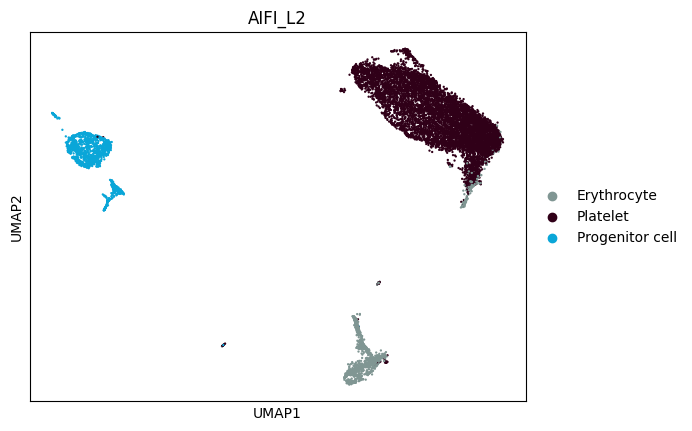

In [21]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L2'
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


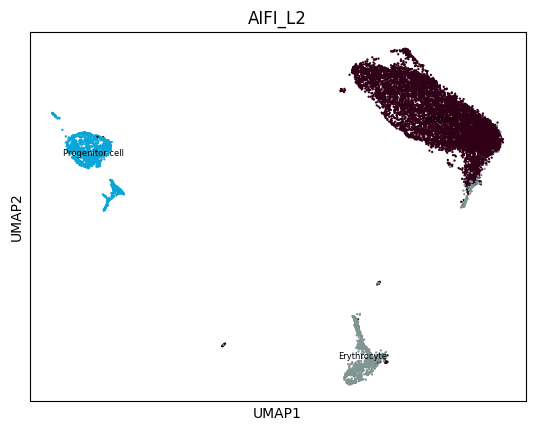

In [22]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L2',
    legend_loc = 'on data',
    legend_fontsize = 6,
    legend_fontweight = 'normal'
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


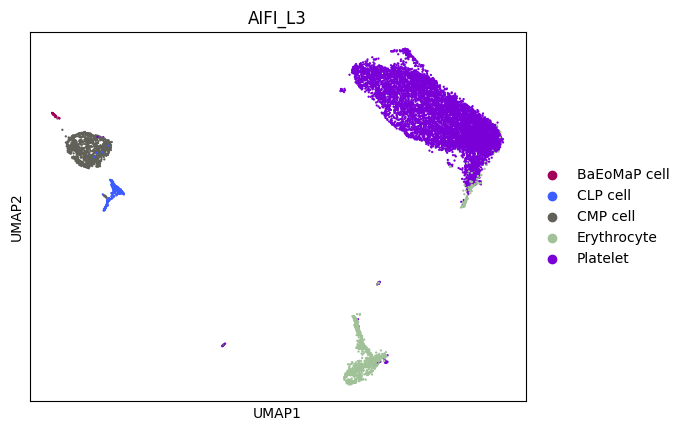

In [23]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L3'
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


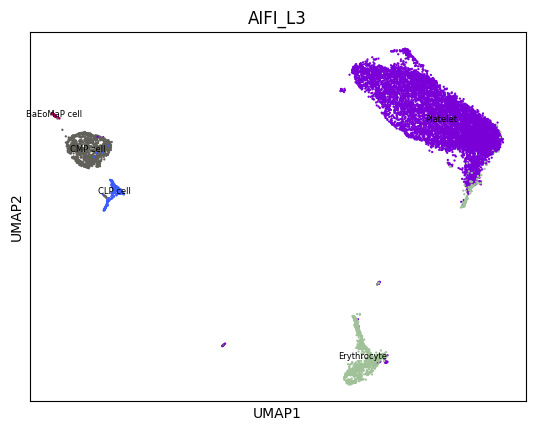

In [24]:
sc.pl.umap(
    adata_subset,
    color = 'AIFI_L3',
    legend_loc = 'on data',
    legend_fontsize = 6,
    legend_fontweight = 'normal'
)

### Output subset annotations

In [25]:
obs = adata_subset.obs
obs = obs.reset_index(drop = True)

In [26]:
umap_mat = adata_subset.obsm['X_umap']
umap_df = pd.DataFrame(umap_mat, columns = ['umap_1', 'umap_2'])
obs['umap_1'] = umap_df['umap_1']
obs['umap_2'] = umap_df['umap_2']

In [27]:
obs.head()

,barcodes,batch_id,cell_name,cell_uuid,chip_id,hto_barcode,hto_category,n_genes,n_mito_umis,n_reads,...,total_counts_mito,log1p_total_counts_mito,pct_counts_mito,leiden,AIFI_L1,AIFI_L2,AIFI_L3,keep,umap_1,umap_2
0,cf76501a48b611ea8957bafe6d70929e,B001,pensive_queasy_tadpole,cf76501a48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,1994,108,22387,...,108,4.691348,1.683817,29,Progenitor cell,Progenitor cell,CMP cell,True,-2.163615,8.717341
1,cf85f11e48b611ea8957bafe6d70929e,B001,ladylike_beauish_barasinga,cf85f11e48b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,820,118,7326,...,118,4.779123,5.214317,21,Platelet,Platelet,Platelet,True,11.469558,11.340449
2,cf85fe6648b611ea8957bafe6d70929e,B001,novel_parttime_motmot,cf85fe6648b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,389,64,2448,...,64,4.174387,8.387942,21,Platelet,Platelet,Platelet,True,14.045321,11.531286
3,cf8bc78848b611ea8957bafe6d70929e,B001,chunky_pretty_lovebird,cf8bc78848b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,483,65,2571,...,65,4.189655,6.951872,21,Platelet,Platelet,Platelet,True,13.294365,12.712489
4,cf99be5648b611ea8957bafe6d70929e,B001,bony_applicable_dorado,cf99be5648b611ea8957bafe6d70929e,B001-P1C1,TGATGGCCTATTGGG,singlet,385,2,2065,...,2,1.098612,0.327869,21,Platelet,Platelet,Platelet,True,12.436749,12.581388


In [28]:
obs_out_csv = '{p}/ref_clean_pbmc_{c}_labeled_meta_umap_{d}.csv'.format(p = out_dir, c = cell_class, d = date.today())
obs.to_csv(obs_out_csv, index = False)
out_files.append(obs_out_csv)

In [29]:
obs_out_parquet = '{p}/ref_clean_pbmc_{c}_labeled_meta_umap_{d}.parquet'.format(p = out_dir, c = cell_class, d = date.today())
obs.to_parquet(obs_out_parquet, index = False)
out_files.append(obs_out_parquet)

### Output subset AnnData

In [31]:
out_h5ad = '{p}/ref_clean_pbmc_{c}_labeled_{d}.h5ad'.format(p = out_dir, c = cell_class, d = date.today())
adata_subset.write_h5ad(out_h5ad)
out_files.append(out_h5ad)

## Upload results to HISE

Finally, we'll use `hisepy.upload.upload_files()` to send a copy of our output to HISE to use for downstream analysis steps.

In [32]:
study_space_uuid = '64097865-486d-43b3-8f94-74994e0a72e0'
title = 'PBMC Clean Reference Other cells {d}'.format(d = date.today())

In [33]:
in_files = [h5ad_uuid]

In [34]:
in_files

['6e8972a5-9463-4230-84b4-a20de055b9c3']

In [35]:
out_files

['output/ref_clean_pbmc_other_labeled_meta_umap_2024-03-09.csv',
 'output/ref_clean_pbmc_other_labeled_meta_umap_2024-03-09.parquet',
 'output/ref_clean_pbmc_other_labeled_2024-03-09.h5ad']

In [36]:
hisepy.upload.upload_files(
    files = out_files,
    study_space_id = study_space_uuid,
    title = title,
    input_file_ids = in_files
)

output/ref_clean_pbmc_other_labeled_meta_umap_2024-03-09.csv
output/ref_clean_pbmc_other_labeled_meta_umap_2024-03-09.parquet
output/ref_clean_pbmc_other_labeled_2024-03-09.h5ad
Cannot determine the current notebook.
1) /home/jupyter/scRNA-Reference-IH-A/05-Assembly/27-Python_clean_Other_cell_projections.ipynb
2) /home/jupyter/scRNA-Reference-IH-A/05-Assembly/26-Python_clean_NK_cell_projections.ipynb
3) /home/jupyter/scRNA-Reference-IH-A/05-Assembly/25-Python_clean_Myeloid_cell_projections.ipynb
Please select (1-3) 


 1


you are trying to upload file_ids... ['output/ref_clean_pbmc_other_labeled_meta_umap_2024-03-09.csv', 'output/ref_clean_pbmc_other_labeled_meta_umap_2024-03-09.parquet', 'output/ref_clean_pbmc_other_labeled_2024-03-09.h5ad']. Do you truly want to proceed?


(y/n) y


{'trace_id': 'ce8750bd-120f-42b3-a9b1-62d2fe886176',
 'files': ['output/ref_clean_pbmc_other_labeled_meta_umap_2024-03-09.csv',
  'output/ref_clean_pbmc_other_labeled_meta_umap_2024-03-09.parquet',
  'output/ref_clean_pbmc_other_labeled_2024-03-09.h5ad']}

In [37]:
import session_info
session_info.show()